In [146]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


notes:
- convert relu to sigmoid
- autoencode - regularize
- returns are reversed fro some reason
- model only has holes when Xs is missing data -build_Xs_from_returns(ret, 10) leads to big holes
- add function to combine different signals (momentum, value, prev returns) 
  - shold allow for returning 2d or 1d
- add convolution layer to build common up/dn forecast

In [2]:
# import pandas.io.data as web
# start_date = datetime.date(2005,1,1)
# end_date = datetime.date(2012,5,1)
# px = web.DataReader(["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"] , 'yahoo', start_date, end_date).Close
# ret = px.div(px.shift()).dropna()
ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0)

In [3]:
risk = .2
scaler = risk / (ret.std() * math.sqrt(250.))
ret = ((ret - 1.) * scaler).applymap(lambda x: x + 1.)

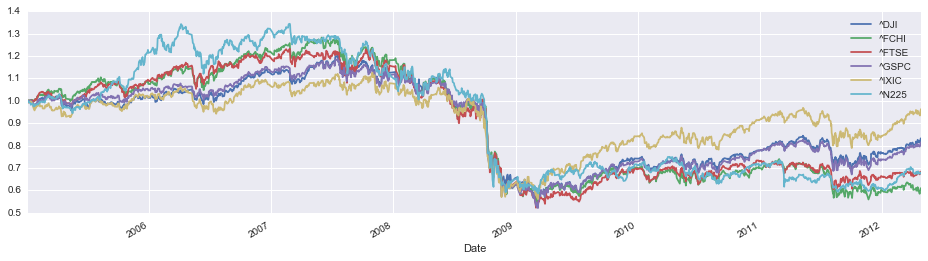

In [4]:
ret.cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [6]:
#grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
#grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

prep model inputs

In [7]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=0.000653, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 1)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [8]:
Xs = build_Xs_from_returns(ret, 10)

model_inputs.py:21: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  weekly = returns_vectors(cum_rets.resample('W', how='last'), per)
model_inputs.py:22: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  monthly = returns_vectors(cum_rets.resample('M', how='last'), per)
model_inputs.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  quarterly = returns_vectors(cum_rets.resample('Q', how='last'), per)


In [232]:
length = 1000
dti = pd.DatetimeIndex(start='2000-1-1', freq='B', periods=length)

#Xs = gen_random_normal(dti, 20)
ys = gen_random_probs(dti, 10)
#ys = gen_random_onehot(dti, 10)
Xs = ys.copy(deep=True)

In [233]:
Xs.equals(ys)

True

In [234]:
print Xs.shape
print ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
print Xs.shape
print ys.shape
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_days=1)
Xs_train, ys_train = train[0].values, train[1].values 

(1000, 10)
(1000, 10)
(1000, 10)
(1000, 10)


In [235]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#Xs, ys = mnist.train.next_batch(1500)

n hidden layers with softmax

In [245]:
ret.resample('B')

/Users/ryanchouck/dev/tf/venv/lib/python2.7/site-packages/IPython/lib/pretty.py:108: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return getattr(obj, attr, default)


,^DJI,^FCHI,^FTSE,^GSPC,^IXIC,^N225
Date,,,,,,
2005-01-05,0.996992,0.992821,0.991876,0.996773,0.993370,0.994473
2005-01-06,1.002294,1.005787,1.003657,1.003118,0.999501,1.003798
2005-01-07,0.998271,1.004551,1.005932,0.998727,0.999441,0.995925
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-11,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-12,1.005660,0.993026,0.993004,1.003541,1.005220,0.994045
2005-01-13,0.989767,1.003848,1.003353,0.992325,0.991171,0.993407
2005-01-14,1.004819,1.004367,1.004101,1.005340,1.007046,1.005601
2005-01-17,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
from model import *
probs, labels, stats = train_nn_softmax(Xs_train, ys_train, [], 50000, 1000, .4)

step     0:	loss: 2.31	(0.05 sec)
step   100:	loss: 2.30	(0.38 sec)
step   200:	loss: 2.29	(0.71 sec)
step   300:	loss: 2.29	(1.03 sec)
step   400:	loss: 2.28	(1.35 sec)
step   500:	loss: 2.28	(1.67 sec)
step   600:	loss: 2.27	(1.95 sec)
step   700:	loss: 2.27	(2.27 sec)
step   800:	loss: 2.27	(2.56 sec)
step   900:	loss: 2.26	(2.88 sec)
step  1000:	loss: 2.26	(3.21 sec)
step  1100:	loss: 2.26	(3.53 sec)
step  1200:	loss: 2.25	(3.86 sec)
step  1300:	loss: 2.25	(4.17 sec)
step  1400:	loss: 2.24	(4.45 sec)
step  1500:	loss: 2.24	(4.78 sec)
step  1600:	loss: 2.24	(5.11 sec)
step  1700:	loss: 2.23	(5.44 sec)
step  1800:	loss: 2.23	(5.77 sec)
step  1900:	loss: 2.23	(6.10 sec)
step  2000:	loss: 2.22	(6.42 sec)
step  2100:	loss: 2.23	(6.80 sec)
step  2200:	loss: 2.22	(7.12 sec)
step  2300:	loss: 2.22	(7.54 sec)
step  2400:	loss: 2.22	(7.90 sec)
step  2500:	loss: 2.21	(8.18 sec)
step  2600:	loss: 2.21	(8.52 sec)
step  2700:	loss: 2.21	(8.85 sec)
step  2800:	loss: 2.21	(9.17 sec)
step  2900:	lo

In [231]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
equal_weight = 1. / probs.shape[1]
dist_from_equal = (probs.mean(axis=0) - equal_weight).abs()
(dist_from_equal < .05).all()

True

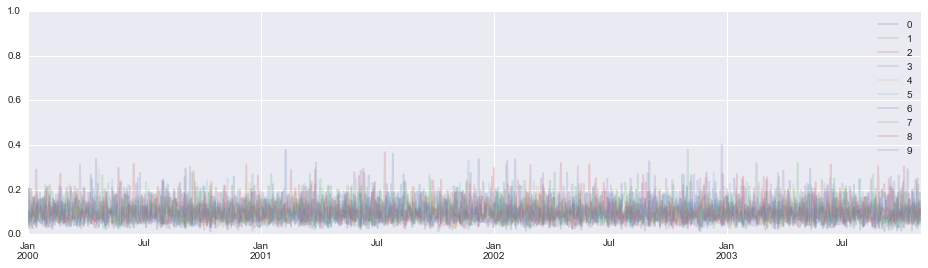

In [224]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.2)

In [14]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
^N225    944
dtype: int64

actual max columns:
^N225    441
^FTSE    136
^IXIC    111
^DJI     108
^FCHI     87
^GSPC     61
dtype: int64


analytics

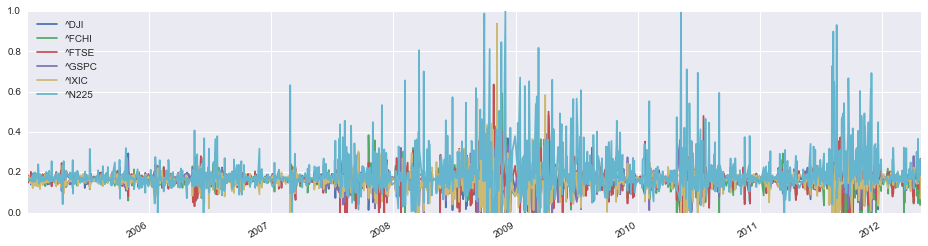

In [15]:
opt_weights.plot(figsize=[16,4], ylim=[0,1])

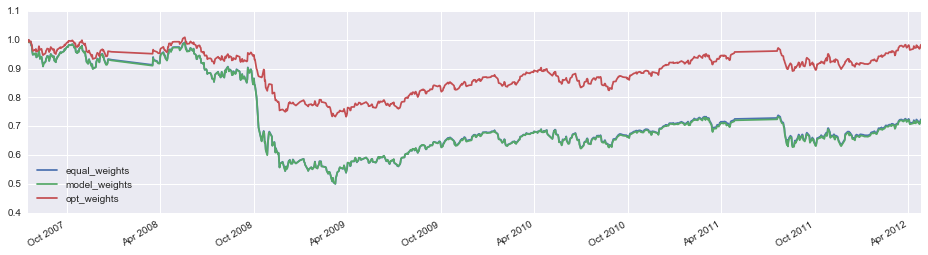

In [37]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.ix[Xs.index].cumprod().plot(figsize=[16,4])